# Gaussian Naive Bayes Classifier #  

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import metrics
import math
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import norm
import time

In [3]:
def gaussian_nll(parameters):
    '''In: array of mu and sigma  Out: value of negative log-likelihood'''
    mu = parameters[0]   
    sigma = parameters[1]
    nll = -np.sum(stats.norm.logpdf(sample_data, loc=mu, scale=sigma))
    return nll

In [4]:
def gaussian_pdf(x, mu, sigma):
    '''In: x: argument; mu ,sigma: parameter for gaussian distribution  Out: value of the gaussian pdf'''
    return (1 / math.sqrt(2 * math.pi * sigma**2)) * math.exp(-((x-mu)**2) / (2 * sigma**2))

In [5]:
def estimate_parameters2(df):
    '''In: dataframe (class labels as last column)  Out: np array columns mean, standard deviation'''
    results = np.empty((1,2))
    for col in range(df.shape[1]-1):
        loc, scale = norm.fit(df.iloc[:, col])
        temp = [loc, scale]
        results = np.vstack([results, temp])
    return results[1:]

In [6]:
def calculate_priors(df):
    '''In: dataframe  Out: 1-d array with priors for each class (length of array = number of classes)'''
    df.sort_values(by=['class_'])
    class_count = df.class_.value_counts()
    class_count = class_count[::-1]
    priors = []
    for row in class_count:
        priors.append(row/df.shape[0])
    return priors

In [7]:
def calculate_probabilities(parameters, x, num_classes, priors):
    '''In: parameters: mu and sigma, x: example, num_classes: number of classes, priors: prior probabilities
    Out: np array with probabilities that x belongs to that class'''
    probabilities = []
    for i in range(num_classes):
        temp_prob = priors[i] #P(class = i)
        for j in range(len(x)):
            temp_prob = temp_prob * norm.pdf(x[j], parameters[i][j][0], parameters[i][j][1]) #P(Xj|class = i)
        probabilities.append(temp_prob)
    probabilities = np.array([probabilities])
    return probabilities

Data processing

In [8]:
iris_data = pd.read_csv('data/iris.data',header=None)
iris_data.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class_']
le = preprocessing.LabelEncoder()
le.fit(iris_data.iloc[:, -1])
label_numeric = le.transform(iris_data.iloc[:,-1])
iris_data.iloc[:,-1] = label_numeric

iris_x_train, iris_x_test, iris_y_train, iris_y_test = train_test_split(iris_data.iloc[:,:-1], iris_data.iloc[:,-1], test_size = 1/3, shuffle = True)

iris_xy_train = pd.concat([iris_x_train, iris_y_train], axis = 1)
iris_xy_test = pd.concat([iris_x_test, iris_y_test], axis = 1)

iris_xy_train0 = iris_xy_train[iris_xy_train.iloc[:,-1] == 0] 
iris_xy_train1 = iris_xy_train[iris_xy_train.iloc[:,-1] == 1]
iris_xy_train2 = iris_xy_train[iris_xy_train.iloc[:,-1] == 2]

In [9]:
seed_data = pd.read_csv('data/seeds.data', header=None)
seed_data.columns = ['area', 'perimeter', 'compactness', 'kernel length', 'width of kernel', 'asymmetry coefficient', 'kernel groove length', 'class_']

seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_data.iloc[1:,:-1], seed_data.iloc[1:,-1], test_size = 1/3, shuffle=True)

seed_xy_train = pd.concat([seed_x_train, seed_y_train], axis = 1)
seed_xy_test = pd.concat([seed_x_test, seed_y_test], axis = 1)

seed_xy_train0 = seed_xy_train[seed_xy_train.iloc[:,-1] == 1]
seed_xy_train1 = seed_xy_train[seed_xy_train.iloc[:,-1] == 2]
seed_xy_train2 = seed_xy_train[seed_xy_train.iloc[:,-1] == 3]

Applying GNB

In [16]:
iris_start = time.time()
iris_result0 = estimate_parameters2(iris_xy_train0)
iris_result1 = estimate_parameters2(iris_xy_train1)
iris_result2 = estimate_parameters2(iris_xy_train2)
iris_result = []
iris_result.append(iris_result0)
iris_result.append(iris_result1)
iris_result.append(iris_result2)

iris_priors = calculate_priors(iris_data)
iris_pred = []
for i in range(len(iris_x_test)):
    temp_prob = calculate_probabilities(iris_result, iris_x_test.iloc[i], 3, iris_priors)
    iris_pred.append((np.argmax(temp_prob, axis=1)).item())
iris_end = time.time()
iris_time = (iris_end - iris_start)
print(f"GNB Iris accuracy:{metrics.accuracy_score(iris_y_test, iris_pred)}")
print(f"GNB Iris runtime: {iris_time}")

GNB Iris accuracy:0.92
GNB Iris runtime: 0.10446381568908691


In [17]:
seed_start = time.time()
seed_result = []
seed_result.append(estimate_parameters2(seed_xy_train0))
seed_result.append(estimate_parameters2(seed_xy_train1))
seed_result.append(estimate_parameters2(seed_xy_train2))
seed_priors = calculate_priors(seed_data)
seed_pred = []
seed_prob = []
for i in range(len(seed_x_test)):
    temp_prob = calculate_probabilities(seed_result, seed_x_test.iloc[i], 3, seed_priors)
    seed_prob.append(temp_prob.tolist())
    seed_pred.append((np.argmax(temp_prob, axis=1)).item()+1)
seed_prob = np.array(seed_prob)
seed_end = time.time()
seed_time = seed_end - seed_start
print(f"GNB Seed accuracy: {metrics.accuracy_score(seed_y_test, seed_pred)}")
print(f"GNB Seed runtime: {seed_time}")

GNB Seed accuracy: 0.8714285714285714
GNB Seed runtime: 0.2227928638458252


In [18]:
knn_iris_start = time.time()
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(iris_x_train, iris_y_train)
iris_knn_y_pred= neigh.predict(iris_x_test)
knn_iris_end = time.time()
knn_iris_time = knn_iris_end - knn_iris_start
print(f"KNN Iris accuracy: {metrics.accuracy_score(iris_y_test, iris_knn_y_pred)}")
print(f"KNN Iris runtime: {knn_iris_time}")

KNN Iris accuracy: 0.98
KNN Iris runtime: 0.009068012237548828


In [19]:
knn_seed_start = time.time()
neigh.fit(seed_x_train, seed_y_train)
seed_knn_y_pred = neigh.predict(seed_x_test)
knn_seed_end = time.time()
knn_seed_time = knn_seed_end - knn_seed_start
print(f"KNN Seed accuracy: {metrics.accuracy_score(seed_y_test, seed_knn_y_pred)}")
print(f"KNN Seed runtime: {knn_seed_time}")

KNN Seed accuracy: 0.9
KNN Seed runtime: 0.009533882141113281


Plotting Results

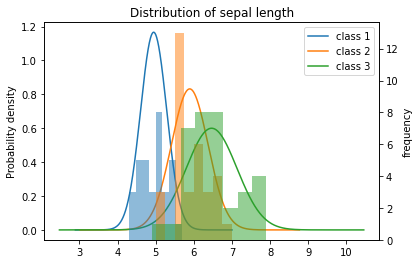

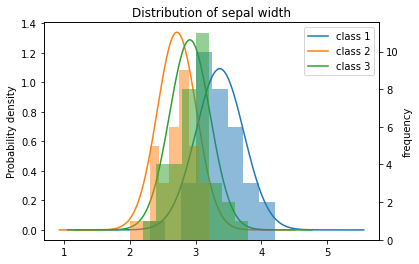

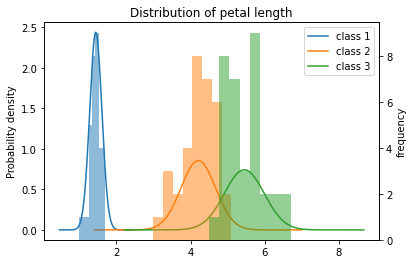

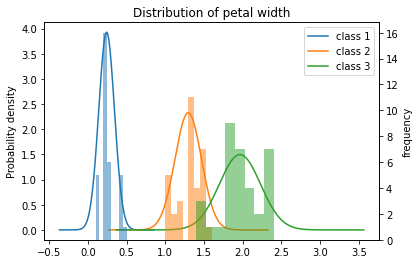

In [20]:
for i in range(4):
    mu0 = iris_result0[i][0]
    sigma0 = iris_result0[i][1]
    mu1 = iris_result1[i][0]
    sigma1 = iris_result1[i][1]
    mu2 = iris_result2[i][0]
    sigma2 = iris_result2[i][1]

    x0 = np.linspace(mu0 - 6*sigma0, mu0 + 6*sigma0, 1000)
    x1 = np.linspace(mu1 - 6*sigma1, mu1 + 6*sigma1, 1000)
    x2 = np.linspace(mu2 - 6*sigma2, mu2 + 6*sigma2, 1000)
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.plot(x0,norm.pdf(x0, mu0, sigma0), label= 'class 1')
    ax.plot(x1,norm.pdf(x1, mu1, sigma1), label= 'class 2')
    ax.plot(x2,norm.pdf(x2, mu2, sigma2), label= 'class 3')

    n, bins, patches = ax2.hist(iris_xy_train0.iloc[:,i], bins=8, alpha=0.5)
    n, bins, patches = ax2.hist(iris_xy_train1.iloc[:,i], bins=8, alpha=0.5)
    n, bins, patches = ax2.hist(iris_xy_train2.iloc[:,i], bins=8, alpha=0.5)
    legend = ['sepal length', 'sepal width', 'petal length', 'petal width']
    title = "Distribution of " + legend[i]
    ax.set_ylabel('Probability density')
    ax2.set_ylabel('frequency')
    plt.title(title)
    ax.legend()
    savename = "iris_features" + str(i) + ".svg"
    #plt.savefig(savename, format='svg', dpi=300)
    plt.show()

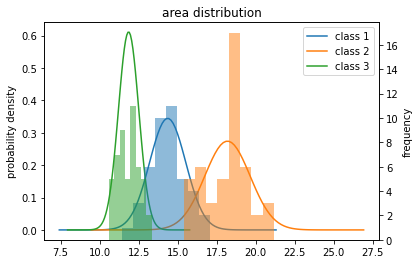

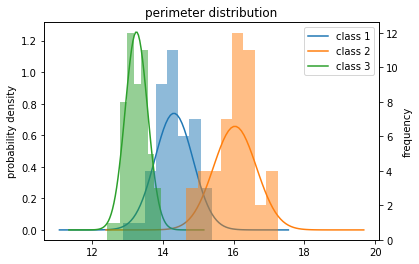

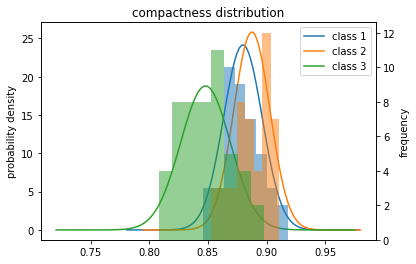

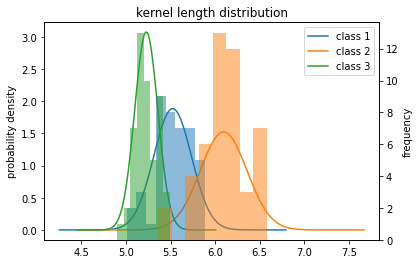

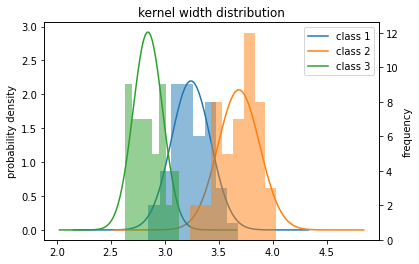

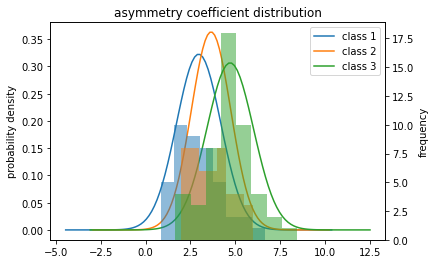

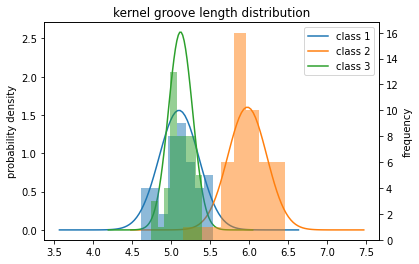

In [21]:
for j in range(7):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    mu = []
    sigma = []
    x = []
    for i in range(3):
        mu.append(seed_result[i][j][0])
        sigma.append(seed_result[i][j][1])
        x.append(np.linspace(mu[i] - 6*sigma[i], mu[i] + 6*sigma[i], 100))
        legend = ['class 1', 'class 2', 'class 3']
        ax.plot(x[i], norm.pdf(x[i], mu[i], sigma[i]), label = legend[i])
        n, bins, patches = ax2.hist(seed_xy_train[seed_xy_train.iloc[:,-1] == i+1].iloc[:,j], bins = 8, alpha = 0.5, label = legend[i])
        ax.legend()
    legend = ['area', 'perimeter', 'compactness', 'kernel length', 'kernel width', 'asymmetry coefficient', 'kernel groove length']
    title = legend[j] + " distribution"
    ax.set_ylabel('probability density')
    ax2.set_ylabel('frequency')
    plt.title(title)
    savename = "seed_features" + str(j) + ".svg"
    #plt.savefig(savename, format='svg', dpi=300)
    plt.show()